In [ ]:
!pip install pytorch-lightning

In [ ]:
%matplotlib inline

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as D
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

In [2]:
from pathlib import Path

# from tqdm.auto import tqdm, trange
from tqdm import tqdm

import sys, os, random, time, json
import numba, cv2, gc
import pickle

In [3]:
from segmentation_models_pytorch import FPN
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch import MAnet
from segmentation_models_pytorch import Linknet
from segmentation_models_pytorch import PAN
import segmentation_models_pytorch as smp

In [4]:
import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

### Setup training variables

In [5]:
!mkdir -p /home/jupyter/data_2/
DATA_PATH = Path('/home/jupyter/data_2/')
assert DATA_PATH.exists()

In [6]:
!mkdir -p /home/jupyter/data/
DATA_PATH_ORIG = Path('/home/jupyter/data/')
assert DATA_PATH_ORIG.exists()

In [7]:
REPORT_PATH = Path('/home/jupyter/reports')
if not REPORT_PATH.exists():
    os.makedirs(REPORT_PATH)
assert REPORT_PATH.exists()

In [8]:
ARCH = 'fpn' # fpn, manet, linknet, pan, unet

WINDOW = 2048 # tile size
MIN_OVERLAP = 32
NEW_SIZE = 1024 # size after re-size which are fed to the model
THRESHOLD = 0
CONTENT_THRESHOLD = 0.001
NUM_WORKERS = 10

FOLDS = 4

BATCH_SIZE = 3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ENCODER_NAME = 'efficientnet-b7'

LR = 1e-3
WD = 1e-3
LABEL_SMOOTH = 0.01
GRAD_ACCU_STEPS = 1
BEST_MODEL = f'best_model_{ARCH}_efficientnetb7_{WINDOW}_{NEW_SIZE}_double_shift_{ENCODER_NAME}.pth'

RESET_IMAGES = False
ENCODER_WEIGHTS = 'imagenet'

SLICES_PATH = Path('/home/jupyter/ds_cache')

EPOCHS = 4
PATIENCE = 10

EXPERIMENT_NAME = f'43_pytorch_{ARCH}_efficientnet_b7_{WINDOW}_{NEW_SIZE}_shifted_slices_groupkfold_smooth_b{BATCH_SIZE}'

In [9]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [10]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [11]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [12]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c  56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f  113277795 21 113315936 53 113354083 87 1133922...
54f2eec69  124967057 36 124997425 109 125027828 147 12505...
4ef6695ce  137041956 58 137081912 65 137121869 72 1371618...
26dc41664  245832956 28 245869925 2 245871115 33 24590808...
c68fe75ea  21256809 3 21283644 10 21310479 17 21337315 22...
afa5e8098  65837968 7 65874765 11 65874827 12 65911562 15...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [13]:
!mkdir {SLICES_PATH}
!mkdir {SLICES_PATH_ORIG}

import shutil

def reset_slices_path():
    shutil.rmtree(SLICES_PATH)
    shutil.rmtree(SLICES_PATH_ORIG)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists
mkdir: cannot create directory ‘{SLICES_PATH_ORIG}’: File exists


### Dataset

In [14]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = CONTENT_THRESHOLD, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [15]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6276, 0.4468, 0.6769], [0.1446, 0.2113, 0.1233])

def read_from_slice(dataset, layers, x1, x2, y1, y2):
    if dataset.count == 3:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
    else:
        image = np.zeros((WINDOW, WINDOW, 3), dtype=np.uint8)
        for fl in range(3):
            image[:,:,fl] = layers[fl].read(window=Window.from_slices((x1,x2),(y1,y2)))
    return image.astype(np.uint8)

def extract_layers(dataset, filepath):
    layers = None
    if dataset.count != 3:
        layers = [rasterio.open(subd) for subd in dataset.subdatasets]
    return layers

In [16]:
if RESET_IMAGES:
    reset_slices_path()

In [17]:
!mkdir {SLICES_PATH}

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


In [18]:
class HubDataset(D.Dataset):
    def __init__(self, root_dir, slices_path, transform, valid_transform=None, mode='train', window=WINDOW, overlap=MIN_OVERLAP, threshold = THRESHOLD):
        self.path, self.slices_path = root_dir, slices_path
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.valid_transform, self.threshold = overlap, window, transform, valid_transform, threshold
        self.mode = mode
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
    def __copy__(self):
        new_ds = type(self)(
            self.path,
            self.slices_path,
            self.transform,
            valid_transform=self.valid_transform,
            mode=self.mode,
            window=self.window,
            overlap=self.overlap,
            threshold=self.threshold
        )
        new_ds.masks = self.masks
        new_ds.files = self.files
        new_ds.slices = self.slices
        new_ds.skipped = self.skipped
        return new_ds
    
    def build_masks(self):
        for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
            filepath = self.path/'train'/f'{filename}.tiff'
            with rasterio.open(filepath) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = self.slices_path/f'slices.pkl'
        files_path = self.slices_path/f'files.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
                print(f'Finished {filename}')
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
        self.build_masks()
                
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
        slices_copy = slices.copy()
        slices_copy_y = slices.copy()
#         # horizontal
        slices_copy[:,(0,1)] += WINDOW // 2 # shift
        slices = np.concatenate ([slices, slices_copy])
#         # vertical
        slices_copy_y[:,(2,3)] += WINDOW // 2
        slices = np.concatenate ([slices, slices_copy_y])
        slices = slices[~(slices[:,1] > dataset_shape[0]),:] # filter those outside of the screen
        slices = slices[~(slices[:,3] > dataset_shape[1]),:] # filter those outside of the screen
        
        layers = extract_layers(dataset, filename)
        
        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, layers, x1, x2 , y1, y2)
#             contains_info = is_tile_contains_info(image)
#             if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask) if self.mode == 'train' else self.valid_transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        mask_torch = torch.from_numpy(mask).to(torch.float16)
        return image, mask_torch
        
    def __getitem__(self, index):
        image_path = self.slices_path/f'image_{index}'
        slices_path = self.slices_path/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                layers = extract_layers(dataset, filename)
                image = read_from_slice(dataset, layers, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(slices_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(slices_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped} mode: {self.mode}'

In [19]:
def generate_ds(size, data_path, slices_path):
    trfm = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.4),
            A.GridDistortion(p=.1, border_mode=cv2.BORDER_REFLECT),
            A.IAAPiecewiseAffine(p=0.4),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=3),
            A.RandomBrightnessContrast(),
            A.RandomGamma()
        ], p=0.5)
    ], p=1.0)
    
    valid_transform = A.Compose([
        A.Resize(size, size, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90()
    ])

    return HubDataset(data_path, slices_path, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm, valid_transform=valid_transform)

In [20]:
ds = generate_ds(NEW_SIZE, DATA_PATH, SLICES_PATH)
ds

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  7%|▋         | 1/15 [00:00<00:01,  9.53it/s]

Reading cached slices, files and masks


100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


total: 4545, skipped: 0 mode: train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


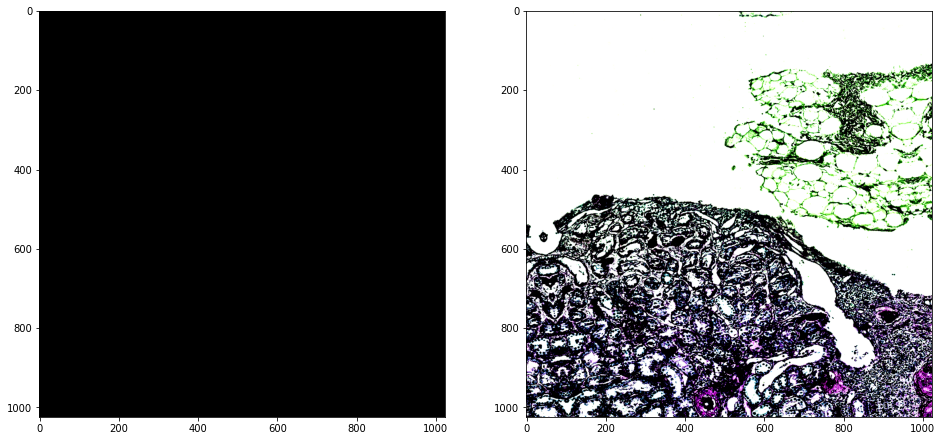

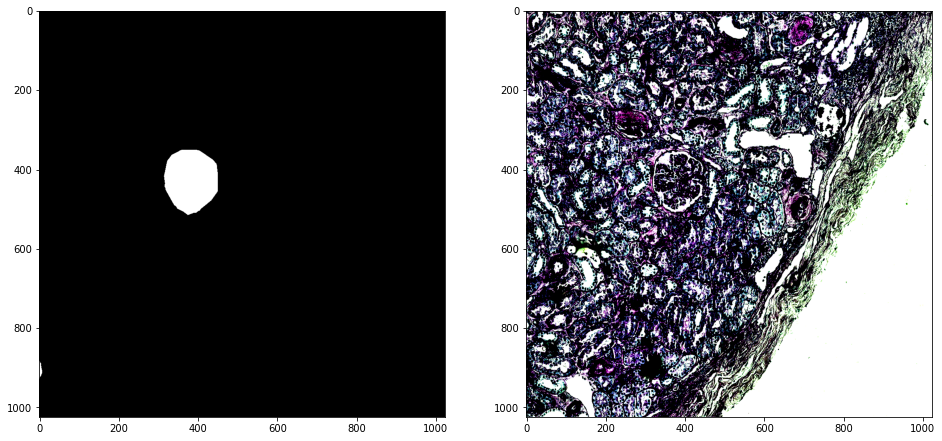

In [21]:
def display_mask_img(idx):
    image, mask = ds[idx]
    mask = mask.to(torch.uint8)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

for i in range(5):
    display_mask_img(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


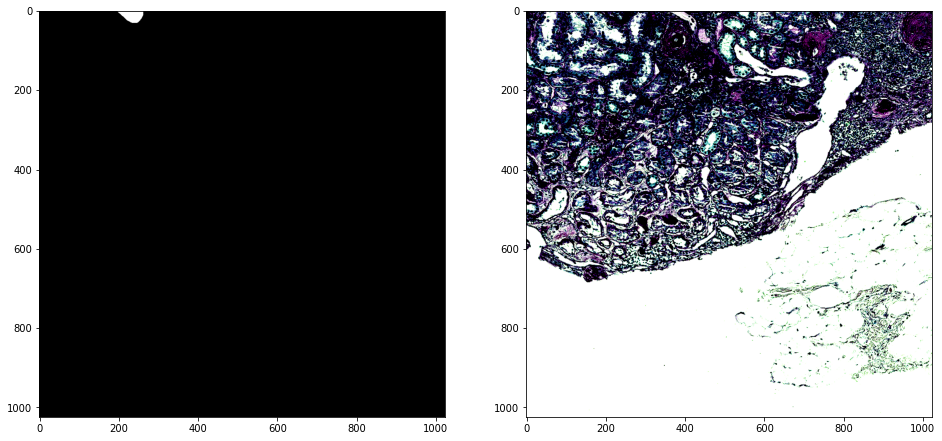

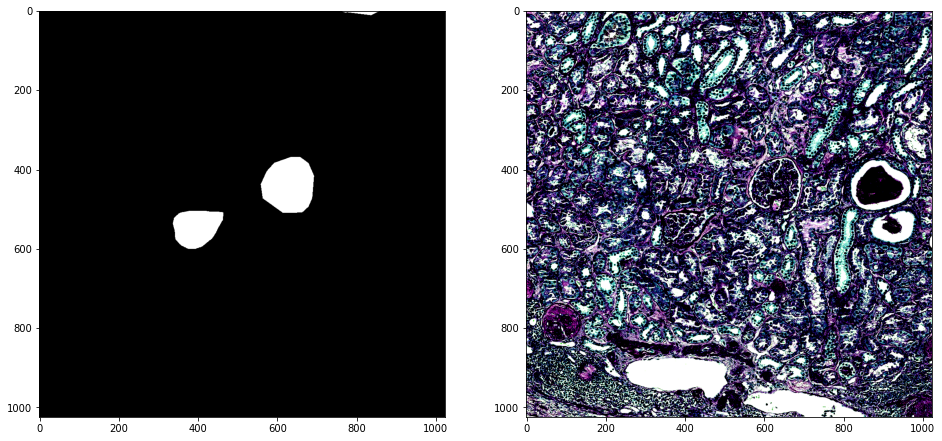

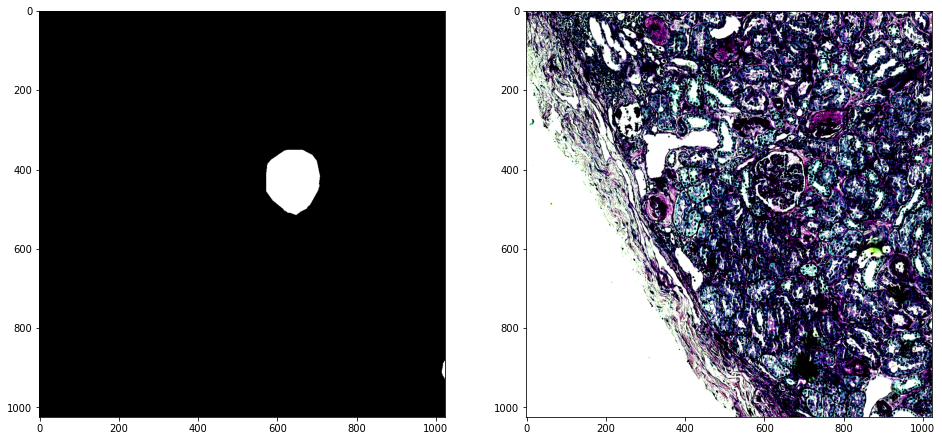

In [22]:
ds.mode = 'valid'

for i in range(5):
    display_mask_img(i)

In [23]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0].numpy().astype('uint8')) # compile function with numba

In [24]:
image.shape

torch.Size([3, 1024, 1024])

#### Split

In [25]:
# Images and its corresponding masks are saved with the same filename.
def generate_fold_info(ds):
    groups = [ds.slices[i][0] for i in range(len(ds))]
    group_kfold = GroupKFold(n_splits = FOLDS)
    fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                            groups = groups)), total=FOLDS)]
    return fold_info

In [26]:
fold_info = generate_fold_info(ds)

100%|██████████| 4/4 [00:00<00:00, 2428.31it/s]


#### Data loaders

In [27]:
import copy

def create_subset(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    val_ds = copy.copy(ds)
    val_ds.mode = 'valid'
    valid_ds = D.Subset(val_ds, valid_idx)
    print(val_ds)
    return train_ds, valid_ds

In [28]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

    num_workers = NUM_WORKERS
    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    return train_dl, valid_dl

In [29]:
def gen_dls(fold):
    train_idx, valid_idx = fold_info[fold]
    print(f'Proportions valid / train: {len(valid_idx) / len(train_idx)}')
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    return train_dl, valid_dl

### Model

In [30]:
class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        args = {
            'encoder_name': ENCODER_NAME, 
            'encoder_weights': ENCODER_WEIGHTS,
            'classes': 1,
            'activation': None,
            'aux_params': None
        }
        if ARCH == 'unet':
            self.model = Unet(**args)
        elif ARCH == 'fpn':
            self.model = FPN(**args)
        elif ARCH == 'manet':
            self.model = MAnet(**args)
        elif ARCH == 'linknet':
            self.model = Linknet(**args)
        elif ARCH == 'pan':
            self.model = PAN(**args)
        
    def forward(self, images):
        return self.model(images)

In [31]:
def get_model():
    model = HuBMAPModel()
#     if torch.cuda.device_count() > 1:
#         print("Let's use", torch.cuda.device_count(), "GPUs!")
#         model = nn.DataParallel(model)
#     model.to(DEVICE)
    return model

### Optimizer

In [32]:
def create_optimizer(model):
    return torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

def create_optimizer_scheduler(model, train_dl_length, epochs):
    optimizer = create_optimizer(model)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=train_dl_length, epochs=epochs)
    return optimizer, scheduler

### Loss

In [33]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [34]:
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=False)

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [35]:
LOSS_ALPHA = 0.4

def loss_fn(y_pred, y_true):
    return LOSS_ALPHA * dice_loss(y_pred.sigmoid(), y_true) + (1 - LOSS_ALPHA) * bce_fn(y_pred, y_true)

### Metric

In [36]:
def dice_metric(y_pred, y, epsilon = 1e-7):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [37]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
dice_metric_2 = smp.utils.metrics.Fscore()

### Training

In [38]:
def smooth_mask_2(mask, alpha = LABEL_SMOOTH):
    return (1 - alpha) * mask + alpha / 2

In [50]:
class LitSegmentationModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = get_model()
        self.criterion = loss_fn
        self.all_metrics = {'dice_metric': dice_metric, 'dice_metric_2': dice_metric_2, 'iou_metric': iou_metric}
        self.learning_rate = LR

    def forward(self, images):
        # in lightning, forward defines the prediction/inference actions
        return self.model(images)

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        image, target = batch
        target = smooth_mask_2(target)
        output = self.model(image)
        loss = self.criterion(output, target)
        self.log('train_loss', loss)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        image, target = batch
        output = self.model(image)
        loss = self.criterion(output, target)

        # Calling self.log will surface up scalars for you in TensorBoard
        metrics = {}
        for k, v in self.all_metrics.items():
            metric_val = v(output, target).item()
            self.log(k, metric_val, prog_bar=True)
            metrics[k] = metric_val
        self.log('val_loss', loss, prog_bar=True)
        return {'val_loss': loss, **metrics}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice_metric = torch.stack([x['dice_metric'] for x in outputs]).mean()
        avg_dice_metric_2 = torch.stack([x['dice_metric_2'] for x in outputs]).mean()
        avg_iou_metric = torch.stack([x['iou_metric'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss, 'dice_metric': avg_dice_metric, 'dice_metric_2': avg_dice_metric_2}
        self.log('val_loss', avg_loss, prog_bar=True)
        self.log('dice_metric', avg_dice_metric, prog_bar=True)
        self.log('dice_metric_2', avg_dice_metric_2, prog_bar=True)
        all_metrics_and_losses = {'val_loss': avg_loss, 'dice_metric': avg_dice_metric, 'dice_metric_2': avg_dice_metric_2, 'avg_iou_metric': avg_iou_metric}
        all_metrics_and_losses = {k:v.item() for (k, v) in all_metrics_and_losses.items()}
        print(f'Epoch: {self.current_epoch} {all_metrics_and_losses}')

    def configure_optimizers(self):
        optimizer, scheduler = create_optimizer_scheduler(self.model, len(self.train_dataloader.dataloader), EPOCHS)
        return [optimizer], [scheduler]
    

In [51]:
LIGHTNING_DIR_PATH = 'lightning_models'

In [52]:
def lightning_train(fold):
    train_dl, valid_dl = gen_dls(fold)
    segmentation_module = LitSegmentationModule()
    checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', dirpath=LIGHTNING_DIR_PATH, filename=f'{fold}-best_model-{ARCH}-{ENCODER_NAME}', save_top_k=1)
    early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=6, verbose=False, mode='min')
    trainer = pl.Trainer(gpus=torch.cuda.device_count(), accelerator="dp", deterministic=True, precision=16, min_epochs=EPOCHS // 4, max_epochs=EPOCHS, gradient_clip_val=1.0, progress_bar_refresh_rate=20, auto_lr_find=True, 
                         callbacks=[checkpoint_callback, early_stop_callback])
#     trainer.tune(segmentation_module)
    trainer.fit(segmentation_module, train_dl, valid_dl)

In [45]:
lightning_train(0)

Proportions valid / train: 0.3285589009061678


  0%|          | 0/15 [00:00<?, ?it/s]

Reading cached slices, files and masks


/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


total: 4545, skipped: 0 mode: valid


/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory lightning_models exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | HuBMAPModel | 65.7 M
--------------------------------------
65.7 M    Trainable params
0         Non-trainable params
65.7 M    Total params
262.663   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': tensor(1.5796, device='cuda:0'), 'dice_metric': tensor(0.1160, device='cuda:0'), 'dice_metric_2': tensor(0.1202, device='cuda:0'), 'avg_iou_metric': tensor(0.0639, device='cuda:0')}


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.6/site-packages/torch/functional.py:1242: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  "torch.norm is deprecated and may be removed in a future PyTorch release. "


Validating: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': tensor(0.0465, device='cuda:0'), 'dice_metric': tensor(0.8952, device='cuda:0'), 'dice_metric_2': tensor(0.9285, device='cuda:0'), 'avg_iou_metric': tensor(0.8698, device='cuda:0')}


Validating: 0it [00:00, ?it/s]

Epoch: 1 {'val_loss': tensor(0.0436, device='cuda:0'), 'dice_metric': tensor(0.9023, device='cuda:0'), 'dice_metric_2': tensor(0.9343, device='cuda:0'), 'avg_iou_metric': tensor(0.8799, device='cuda:0')}


Validating: 0it [00:00, ?it/s]

Epoch: 2 {'val_loss': tensor(0.0440, device='cuda:0'), 'dice_metric': tensor(0.9017, device='cuda:0'), 'dice_metric_2': tensor(0.9329, device='cuda:0'), 'avg_iou_metric': tensor(0.8783, device='cuda:0')}


Validating: 0it [00:00, ?it/s]

Epoch: 3 {'val_loss': tensor(0.0442, device='cuda:0'), 'dice_metric': tensor(0.9070, device='cuda:0'), 'dice_metric_2': tensor(0.9345, device='cuda:0'), 'avg_iou_metric': tensor(0.8797, device='cuda:0')}


In [53]:
lightning_train(1)

Proportions valid / train: 0.3399174528301887


  0%|          | 0/15 [00:00<?, ?it/s]

Reading cached slices, files and masks


100%|██████████| 15/15 [00:02<00:00,  5.11it/s]


total: 4545, skipped: 0 mode: valid


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | HuBMAPModel | 65.7 M
--------------------------------------
65.7 M    Trainable params
0         Non-trainable params
65.7 M    Total params
262.663   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': 0.828540563583374, 'dice_metric': 0.03258461877703667, 'dice_metric_2': 0.027698762714862823, 'avg_iou_metric': 0.01405043713748455}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': 0.044924162328243256, 'dice_metric': 0.9098442196846008, 'dice_metric_2': 0.9337701797485352, 'avg_iou_metric': 0.8771561980247498}


Validating: 0it [00:00, ?it/s]

Epoch: 1 {'val_loss': 0.04181820526719093, 'dice_metric': 0.9090574979782104, 'dice_metric_2': 0.935420572757721, 'avg_iou_metric': 0.8802730441093445}


Validating: 0it [00:00, ?it/s]

Epoch: 2 {'val_loss': 0.03925766795873642, 'dice_metric': 0.9212018251419067, 'dice_metric_2': 0.9410340785980225, 'avg_iou_metric': 0.8895612359046936}


Validating: 0it [00:00, ?it/s]

Epoch: 3 {'val_loss': 0.03969313204288483, 'dice_metric': 0.914476752281189, 'dice_metric_2': 0.9394391775131226, 'avg_iou_metric': 0.8871616721153259}


In [54]:
lightning_train(2)

  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.33715798764342453
Reading cached slices, files and masks


100%|██████████| 15/15 [00:02<00:00,  5.01it/s]


total: 4545, skipped: 0 mode: valid


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | HuBMAPModel | 65.7 M
--------------------------------------
65.7 M    Trainable params
0         Non-trainable params
65.7 M    Total params
262.663   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': 1.0667146444320679, 'dice_metric': 0.027464943006634712, 'dice_metric_2': 0.02342606708407402, 'avg_iou_metric': 0.011910708621144295}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': 0.059802111238241196, 'dice_metric': 0.865427553653717, 'dice_metric_2': 0.9043388962745667, 'avg_iou_metric': 0.8343945145606995}


Validating: 0it [00:00, ?it/s]

Epoch: 1 {'val_loss': 0.0642215684056282, 'dice_metric': 0.8577909469604492, 'dice_metric_2': 0.8986507058143616, 'avg_iou_metric': 0.8329716920852661}


Validating: 0it [00:00, ?it/s]

Epoch: 2 {'val_loss': 0.05783301964402199, 'dice_metric': 0.8698854446411133, 'dice_metric_2': 0.905448853969574, 'avg_iou_metric': 0.8388053774833679}


Validating: 0it [00:00, ?it/s]

Epoch: 3 {'val_loss': 0.060019899159669876, 'dice_metric': 0.8676494359970093, 'dice_metric_2': 0.9071525931358337, 'avg_iou_metric': 0.8415468335151672}


In [55]:
lightning_train(3)

  0%|          | 0/15 [00:00<?, ?it/s]

Proportions valid / train: 0.32778264680105174
Reading cached slices, files and masks


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


total: 4545, skipped: 0 mode: valid


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | HuBMAPModel | 65.7 M
--------------------------------------
65.7 M    Trainable params
0         Non-trainable params
65.7 M    Total params
262.663   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': 0.49387139081954956, 'dice_metric': 0.004596133250743151, 'dice_metric_2': 0.0008465694263577461, 'avg_iou_metric': 0.0004235745291225612}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch: 0 {'val_loss': 0.058658938854932785, 'dice_metric': 0.8679700493812561, 'dice_metric_2': 0.9070985317230225, 'avg_iou_metric': 0.8402280807495117}


Validating: 0it [00:00, ?it/s]

Epoch: 1 {'val_loss': 0.05521136894822121, 'dice_metric': 0.8744456171989441, 'dice_metric_2': 0.9162707328796387, 'avg_iou_metric': 0.8546497821807861}


Validating: 0it [00:00, ?it/s]

Epoch: 2 {'val_loss': 0.04906301945447922, 'dice_metric': 0.88764488697052, 'dice_metric_2': 0.9236634969711304, 'avg_iou_metric': 0.8644545078277588}


Validating: 0it [00:00, ?it/s]

Epoch: 3 {'val_loss': 0.05182783305644989, 'dice_metric': 0.8839784860610962, 'dice_metric_2': 0.9208446145057678, 'avg_iou_metric': 0.8623218536376953}


In [56]:
for fold in range(FOLDS):
    segmentation_module = LitSegmentationModule()
    segmentation_module.load_from_checkpoint(f'{LIGHTNING_DIR_PATH}/{fold}-best_model-{ARCH}-{ENCODER_NAME}.ckpt')
    if torch.cuda.device_count() > 1:
        torch.save(segmentation_module.model.module.state_dict(), f'{LIGHTNING_DIR_PATH}/{fold}-{BEST_MODEL}')
    else:
        torch.save(segmentation_module.model.state_dict(), f'{LIGHTNING_DIR_PATH}/{fold}-{BEST_MODEL}')